In [1]:
import numpy as np
import yaml
import json
import os

# from silence_tensorflow import silence_tensorflow
# silence_tensorflow()
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_addons as tfa
import tensorflow as tf

from utils.image_augmentation import get_blur_layer
from utils.train.callbacks import EncoderCheckpoint, ResetBatchIndex, Logger
from utils.models.barlow_twins import BarlowTwins
from utils.datasets import get_dataset_df
from utils import image_augmentation
from utils.train.lr_scheduler import get_decay_fn
from utils.models import resnet_cifar, resnet
from utils.misc import log_config

In [2]:
def configure_saving(model_name):
    print('Model name:', model_name)

    save_dir = os.path.join(config['root_save_dir'], model_name)
    config['save_dir'] = save_dir

    try:
        os.makedirs(save_dir, exist_ok=False)
    except FileExistsError:
        input_ = input('save_dir already exists, continue? (Y/n)  >> ')
        if input_ != 'Y':
            raise ValueError

    return save_dir

In [3]:
def load_dataset():
    # Only using training set (and no validation set)
    df = get_dataset_df(config['dataset_config'], config['random_seed'], mode='encoder')
    # Shuffle the dataset (NumPy random seed)
    df = df.sample(frac=1).reset_index(drop=True)
    print('Dataset length:', len(df))

    # Generate one dataset for each view
    # Data generation seems to be buggy when this is done in a loop...
    datagen_a = ImageDataGenerator(rescale=1. / 225).flow_from_dataframe(
        df[df['split'] == 'train'],
        shuffle=False,
        seed=config['random_seed'],
        target_size=config['image_shape'][:2], 
        batch_size=config['batch_size']
    )

    datagen_b = ImageDataGenerator(rescale=1. / 225).flow_from_dataframe(
        df[df['split'] == 'train'],
        shuffle=False,
        seed=config['random_seed'],
        target_size=config['image_shape'][:2], 
        batch_size=config['batch_size']
    )

    ds_a = tf.data.Dataset.from_generator(lambda: [datagen_a.next()[0]], output_types='float32',
                                          output_shapes=[None] * 4)
    ds_a = ds_a.map(
        lambda x: image_augmentation.augment(x, 0, config=config['preprocessing_config']),
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    ds_a = ds_a.map(lambda x: tf.clip_by_value(x, 0, 1), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    ds_b = tf.data.Dataset.from_generator(lambda: [datagen_b.next()[0]], output_types='float32',
                                          output_shapes=[None] * 4)
    ds_b = ds_b.map(
        lambda x: image_augmentation.augment(x, 1, config=config['preprocessing_config']),
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    ds_b = ds_b.map(lambda x: tf.clip_by_value(x, 0, 1), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    dataset = tf.data.Dataset.zip((ds_a, ds_b))
    dataset = dataset.prefetch(config['prefetch'])

    # This creates a generator from the dataset
    def get_generator():
        while True:
            yield next(iter(dataset))

    steps_per_epoch = len(datagen_a)
    config['steps_per_epoch'] = steps_per_epoch
    print('Steps per epoch:', steps_per_epoch)

    return get_generator(), [datagen_a, datagen_b]

In [4]:
def load_model():
    strategy = tf.distribute.MirroredStrategy(config['gpu_used'])
    print('Number of devices:', strategy.num_replicas_in_sync)

    with strategy.scope():
        if config['cifar_resnet']:
            resnet_enc = resnet_cifar.get_network(
                n=2,
                hidden_dim=config['projector_dim'],
                use_pred=False,
                return_before_head=False,
                input_shape=config['image_shape'])
        else:
            resnet_enc = resnet.get_barlow_encoder(config['image_shape'], config['projector_dim'], hidden_layers=3)

        blur_layer = get_blur_layer(config['filter_size'], config['image_shape'])

        # Load optimizer
        lr_decay_fn = get_decay_fn(config['lr_base'], config['epochs'], config['steps_per_epoch'])

        if config['use_lamb']:
            optimizer = tfa.optimizers.LAMB(
                learning_rate=lr_decay_fn,
                weight_decay_rate=config['weight_decay']
            )
        else:
            optimizer = tf.keras.optimizers.Adam(lr_decay_fn)

        # Get model
        barlow_twins = BarlowTwins(
            resnet_enc, blur_layer=blur_layer,
            preprocessing_config=config['preprocessing_config'],
            batch_size=config['batch_size']
        )
        barlow_twins.compile(optimizer=optimizer)

        print('Barlow twins blur probabilities:', barlow_twins.blur_probabilities)

    # This is necessary to prevent TensorFlow from raising an exception
    barlow_twins.built = True
    barlow_twins.summary()

    return barlow_twins, resnet_enc

In [5]:
with open('config/encoder_config.yaml') as file:
    config = yaml.safe_load(file)

config['use_lamb'] = False
config['lr_base'] = 1e-3
# Adjusts learning rate according to the batch size
config['lr_base'] = config['lr_base'] * config['batch_size'] / 256
config['epochs'] = 100
config['projector_dim'] = 4096

# Set random seed
np.random.seed(config['random_seed'])
tf.random.set_seed(config['random_seed'])

In [6]:
save_dir = configure_saving('adam_100_4096')
print('Saving at:', save_dir)

dataset, datagens = load_dataset()
barlow_twins, resnet_enc = load_model()

callbacks = []
if config['patience'] is not None:
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=config['patience'])
    callbacks.append(es)

mc = EncoderCheckpoint(resnet_enc, save_dir)
callbacks.append(mc)

callbacks.append(ResetBatchIndex(datagens))
callbacks.append(Logger())

log_config(config, save_config=True)

Model name: adam_100_4096
Saving at: trained_models/encoders/adam_100_4096
Dataset length: 179926
Found 158001 validated image filenames belonging to 1 classes.
Found 158001 validated image filenames belonging to 1 classes.
Steps per epoch: 618
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:

In [ ]:
history = barlow_twins.fit(
    dataset,
    epochs=config['epochs'],
    steps_per_epoch=config['steps_per_epoch'],
    callbacks=callbacks
)

Epoch 1/100
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:batch_all_reduce: 186 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 186 all-reduces with algorithm = nccl, num_packs = 1
618/618 [==============================] - ETA: 0s - loss: 2608.0791
Saving model, new lowest loss: 2608.0791015625
Finished saving ==> doing great!
618/618 [==============================] - 1766s 3s/step - loss: 2608.0791
Epoch 2/100
618/618 [==============================] - ETA: 0s - loss: 1481.6720
Saving model, new lowest loss: 1481.6719970703125
Finished saving ==> doing great!
618/618 [==============================] - 1770s 3s/step - loss: 1481.6720
Epoch 3/100
618/618 [==============================] - 1768s 3s/step - loss: 1483.8002
Epoch 4/100
550/618 [=========================>....] - ETA: 3:15 - loss: 1485.1223

In [11]:
# Save training history
with open(os.path.join(save_dir, 'history.json'), 'w') as f:
    json.dump(history.history, f)

# Save weights for the best ResNet backbone
resnet_enc.load_weights(os.path.join(save_dir, 'encoder.h5'))
resnet_enc.layers[1].save_weights(os.path.join(save_dir, 'resnet.h5'))

In [13]:
import matplotlib.pyplot as plt

def check_imgs(a, b):
    print([datagen.batch_index for datagen in datagens])
    
    plt.axis('off')
    plt.imshow(np.hstack(a[:5]))
    plt.show()
    
    plt.axis('off')
    plt.imshow(np.hstack(b[:5]))
    plt.show()

[0, 0]
(64, 224, 224, 3) (64, 224, 224, 3)
[1, 1]


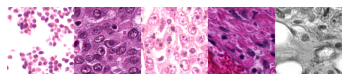

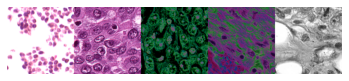

In [28]:
datagens[0].batch_index = 0
datagens[1].batch_index = 0

print([datagen.batch_index for datagen in datagens])
a, b = next(iter(dataset))
print(a.shape, b.shape)
check_imgs(a, b)